In [1]:
import matplotlib.pyplot as plt
import pylandstats as pls
import seaborn as sns
import swisslandstats as sls
from shapely.geometry import Point

from swiss_urbanization.data import settings

sns.set()

In [2]:
urban_class = settings.EXTRACTS_URBAN
nodata = settings.EXTRACTS_NODATA

agglomeration_slugs = ['bern', 'lausanne', 'zurich']

buffer_dists = list(range(1000, 20000, 1000))
# TODO: change hardcoded points and use overpass API filtering by tag
# `admin_centre:4=yes`
base_mask_dict = {
    'bern': Point(7.4514512, 46.9482713),
    'lausanne': Point(6.6327025, 46.5218269),
    'zurich': Point(8.5414061, 47.3769434)
}
base_mask_crs = {'init':'epsg:4326'}

In [3]:
agglomeration_dict = {}
for agglomeration_slug in agglomeration_slugs:
    _dict = {}
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglomeration_slug}.csv')
    base_mask = base_mask_dict[agglomeration_slug]
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        year = ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0]
        _dict[year] = pls.BufferAnalysis(
            pls.Landscape(
                ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                res=ldf.res,
                nodata=nodata),
            base_mask,
            buffer_dists=buffer_dists,
            base_mask_crs=base_mask_crs,
            landscape_crs=ldf.crs,
            landscape_transform=ldf.get_transform(),
            metrics=['total_area'],
            classes=[urban_class])
    agglomeration_dict[agglomeration_slug] = _dict

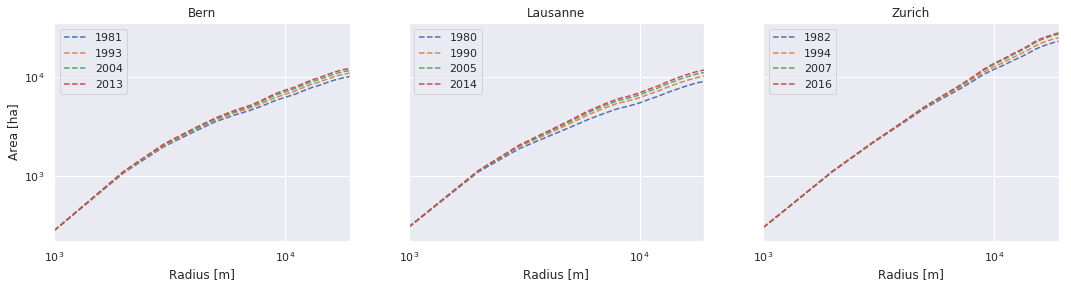

In [4]:
num_agglomerations = len(agglomeration_slugs)

figwidth, figheight = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(num_agglomerations*figwidth, figheight))
ax = None  # to pass as `sharey` argument in the first iteration

for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    _dict = agglomeration_dict[agglomeration_slug]
    ax = fig.add_subplot(1, num_agglomerations, i, sharey=ax)
    for year in _dict:
        _dict[year].class_metrics_df.loc[urban_class]['total_area'].plot(
        loglog=True, ax=ax, label=year, linestyle='dashed')
    ax.legend()
    ax.set_xlabel('Radius [m]')
    ax.set_title(agglomeration_slug.capitalize())

fig.axes[0].set_ylabel('Area [ha]')
fig.savefig('../reports/figures/bifractal_radial_dimension.pdf', dpi=300,
            bbox_inches='tight', pad_inches=0)